# Implementation of the TagRateFunction method in awk+correctionlib 

In [1]:
%load_ext memory_profiler

In [2]:
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
import numpy as np
import awkward as ak
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from pprint import pprint
import numba
from numba import njit
from numba.typed import List, Dict
import correctionlib, rich
import correctionlib.convert
from hist import Hist

In [3]:
filename = "root://xrootd-cms.infn.it///store/mc/RunIISummer20UL18NanoAODv9/ttHTobb_M125_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v2/250000/32D0D1A3-74EB-8146-9F3F-B392AB168FDD.root"
events = NanoEventsFactory.from_root(filename, schemaclass=NanoAODSchema, entry_stop=100000).events()

# Extract the b-tagger efficiencies

In [14]:
btagged = (Hist.new.Reg(20, 0, 400,overflow=True, underflow=False, name="pt" )
                .Reg(10, -4, 4, overflow=False, underflow=False, name="eta")
                .Int(0,3, name="flavour")
                .Weight())
non_btagged = (Hist.new.Reg(20, 0, 400,overflow=True, underflow=False, name="pt" )
                .Reg(10, -4, 4, overflow=False, underflow=False, name="eta")
                .Int(0,3, name="flavour")
                .Weight())

In [15]:
bJets = events.Jet[events.Jet.btagDeepFlavB > 0.277]
bJets_L = bJets[bJets.hadronFlavour==0]
bJets_C = bJets[bJets.hadronFlavour==4]
bJets_B = bJets[bJets.hadronFlavour==5]

bJets_flavour = ak.where(bJets.hadronFlavour!=0, bJets.hadronFlavour-3, 0.)

jets_L = events.Jet[events.Jet.hadronFlavour==0]
jets_C = events.Jet[events.Jet.hadronFlavour==4]
jets_B = events.Jet[events.Jet.hadronFlavour==5]

jets_flavour = ak.where(events.Jet.hadronFlavour!=0, events.Jet.hadronFlavour-3, 0.)


In [16]:
print(ak.num(bJets_L))
print(ak.num(bJets_C))
print(ak.num(bJets_B))

[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, ... 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ... 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[2, 3, 4, 3, 2, 4, 3, 2, 1, 4, 3, 3, 2, 2, ... 3, 2, 2, 2, 2, 3, 2, 2, 3, 3, 3, 1, 2]


In [17]:
print(ak.num(jets_L))
print(ak.num(jets_C))
print(ak.num(jets_B))

[4, 5, 4, 4, 4, 5, 7, 4, 4, 5, 1, 8, 4, ... 6, 10, 5, 3, 6, 6, 6, 4, 6, 4, 7, 10, 11]
[1, 0, 1, 1, 1, 1, 0, 1, 2, 2, 1, 1, 1, 0, ... 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]
[4, 3, 4, 4, 3, 4, 3, 3, 1, 4, 4, 4, 4, 3, ... 3, 3, 4, 4, 4, 3, 2, 3, 4, 3, 3, 4, 3]


In [18]:
btagged.fill(ak.flatten(bJets.pt),
             ak.flatten(bJets.eta),
             ak.flatten(bJets_flavour))

Hist(
  Regular(20, 0, 400, underflow=False, name='pt'),
  Regular(10, -4, 4, underflow=False, overflow=False, name='eta'),
  Integer(0, 3, name='flavour'),
  storage=Weight()) # Sum: WeightedSum(value=175821, variance=175821) (WeightedSum(value=177210, variance=177210) with flow)

In [19]:
non_btagged.fill(ak.flatten(events.Jet.pt),
             ak.flatten(events.Jet.eta),
             ak.flatten(jets_flavour))

Hist(
  Regular(20, 0, 400, underflow=False, name='pt'),
  Regular(10, -4, 4, underflow=False, overflow=False, name='eta'),
  Integer(0, 3, name='flavour'),
  storage=Weight()) # Sum: WeightedSum(value=572449, variance=572449) (WeightedSum(value=575835, variance=575835) with flow)

In [20]:
btagged[{"flavour":2}]

Hist(
  Regular(20, 0, 400, underflow=False, name='pt'),
  Regular(10, -4, 4, underflow=False, overflow=False, name='eta'),
  storage=Weight()) # Sum: WeightedSum(value=161101, variance=161101) (WeightedSum(value=162336, variance=162336) with flow)

In [21]:
non_btagged[{"flavour":2}]

Hist(
  Regular(20, 0, 400, underflow=False, name='pt'),
  Regular(10, -4, 4, underflow=False, overflow=False, name='eta'),
  storage=Weight()) # Sum: WeightedSum(value=205674, variance=205674) (WeightedSum(value=207170, variance=207170) with flow)

### Let's save the efficiency in correctionlib format

In [22]:
w_num,  x, y, z = btagged.to_numpy()
num_var = btagged.variances()
w_denom,  x, y, z  = non_btagged.to_numpy()
denom_var = non_btagged.variances()

ratio= np.where( (w_denom>0)&(w_num>0), w_num/w_denom, 1.) 
ratio_err =  np.where( (w_denom>0)&(w_num>0),
                      np.sqrt((1/w_denom)**2 * num_var + (w_num/w_denom**2)**2 * denom_var),
                      0.)

#recreate the histo
sfhist = ( Hist.new.Reg(20, 0, 400,overflow=True, underflow=False, name="pt" )
                .Reg(10, -5, 5, overflow=False, underflow=False, name="eta")
                .Int(0,3, name="flavour")
           .Double(data=ratio))



/tmp/ipykernel_2455/875839267.py:6: RuntimeWarning: invalid value encountered in divide
  ratio= np.where( (w_denom>0)&(w_num>0), w_num/w_denom, 1.)
/tmp/ipykernel_2455/875839267.py:8: RuntimeWarning: divide by zero encountered in divide
  np.sqrt((1/w_denom)**2 * num_var + (w_num/w_denom**2)**2 * denom_var),
/tmp/ipykernel_2455/875839267.py:8: RuntimeWarning: invalid value encountered in multiply
  np.sqrt((1/w_denom)**2 * num_var + (w_num/w_denom**2)**2 * denom_var),
/tmp/ipykernel_2455/875839267.py:8: RuntimeWarning: invalid value encountered in divide
  np.sqrt((1/w_denom)**2 * num_var + (w_num/w_denom**2)**2 * denom_var),


In [23]:
# without a name, the resulting object will fail validation
sfhist.name = "TRF_efficiencies"
sfhist.label = "out"
clibcorr = correctionlib.convert.from_histogram(sfhist)
clibcorr.description = "Btagging efficiency by pt, eta, flavour"

# set overflow bins behavior (default is to raise an error when out of bounds)
clibcorr.data.flow = "clamp"

cset = correctionlib.schemav2.CorrectionSet(
    schema_version=2,
    description="trf efficiency",
    corrections=[clibcorr],
)
rich.print(cset)

with open("test_trf.json", "w") as fout:
    fout.write(cset.json(exclude_unset=True))

CorrectionSet (schema v2)
trf efficiency
📂
└── 📈 TRF_efficiencies (v0)
    Btagging efficiency by pt, eta, flavour
    Node counts: MultiBinning: 1, Category: 200
    ╭──────────── ▶ input ─────────────╮ ╭──────────── ▶ input ────────────╮ ╭──── ▶ input ────╮
    │ pt (real)                        │ │ eta (real)                      │ │ flavour (int)   │
    │ pt                               │ │ eta                             │ │ flavour         │
    │ Range: [0.0, 400.0), overflow ok │ │ Range: [-5.0, 5.0), overflow ok │ │ Values: 0, 1, 2 │
    ╰──────────────────────────────────╯ ╰─────────────────────────────────╯ ╰─────────────────╯
    ╭─── ◀ output ───╮
    │ out (real)     │
    │ No description │
    ╰────────────────╯

In [24]:
cset = correctionlib.CorrectionSet.from_file("test_trf.json")
corr = cset["TRF_efficiencies"]

In [25]:
corr.evaluate(ak.flatten(bJets.pt), ak.flatten(bJets.eta), ak.flatten(bJets_flavour ))

array([0.7592535 , 0.78964059, 0.85153049, ..., 0.82711348, 0.82206897,
       0.85060034])

# Compute the TRF probability

In [4]:
mask = ak.num(events.Jet)>=4
jet_pt = ak.flatten(events[mask].Jet.pt)
jet_eta = ak.flatten(events[mask].Jet.eta)
jet_flavour = ak.where(events[mask].Jet.hadronFlavour!=0, events[mask].Jet.hadronFlavour-3, 0.)
jet_fl = ak.flatten(jet_flavour)

num_jets = ak.num(events[mask].Jet)

bJets = events[mask].Jet[events[mask].Jet.btagDeepFlavB > 0.277]
nBjets = ak.num(bJets)

nGenBJets = ak.sum(jet_flavour==2, axis=1)

In [5]:
cset = correctionlib.CorrectionSet.from_file("test_trf.json")
corr = cset["TRF_efficiencies"]
eff = corr.evaluate(jet_pt, jet_eta, jet_fl)

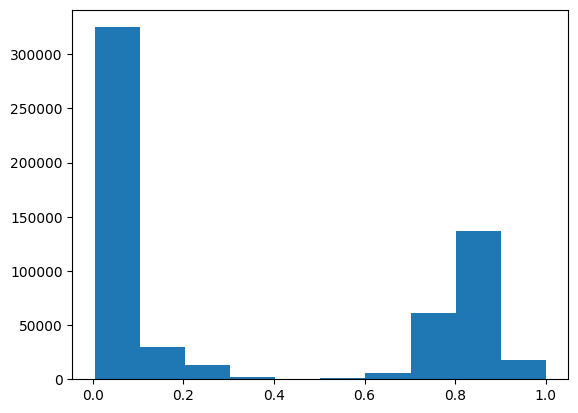

In [6]:
eff_j = ak.unflatten(eff, num_jets)
plt.hist(ak.flatten(eff_j));

## Computing combinations without repetitions

In [29]:
#@numba.jit(nopython=False)
def comb_index(n, k):
    count = comb(n,k, exact=True)
    index = np.fromiter(chain.from_iterable(combinations(range(n), k)), 
                        int, count=count*k)
    return index.reshape(-1, k)

In [15]:
%%timeit
comb_index(15, 4)

199 µs ± 35.7 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [16]:
out = comb_index(10, 3)

This is very fast, but if I use it in numba it falls back in nopython mode. 

### Combinations directly in numba

In [7]:
#Pure numba combinations implementation
#taken from https://stackoverflow.com/questions/61262188/numba-safe-version-of-itertools-combinations
@njit
def combinations_numba(n, r):
    pool = list(range(n))
    indices = list(range(r))
    empty = not(n and (0 < r <= n))

    if not empty:
        result = [pool[i] for i in indices]
        yield result

    while not empty:
        i = r - 1
        while i >= 0 and indices[i] == i + n - r:
            i -= 1
        if i < 0:
            empty = True
        else:
            indices[i] += 1
            for j in range(i+1, r):
                indices[j] = indices[j-1] + 1

            result = [pool[i] for i in indices]
            yield result
            
            
@njit
def combinations_numba_nogenerator(n, r):
    pool = list(range(n))
    indices = list(range(r))
    empty = not(n and (0 < r <= n))
    results = [list(range(x)) for x in range(0)]
    
    if not empty:
        result = [pool[i] for i in indices]
        results.append(result)

    while not empty:
        i = r - 1
        while i >= 0 and indices[i] == i + n - r:
            i -= 1
        if i < 0:
            empty = True
        else:
            indices[i] += 1
            for j in range(i+1, r):
                indices[j] = indices[j-1] + 1

            result = [pool[i] for i in indices]
            results.append(result)
    return results

In [30]:
%%timeit
list(combinations_numba(25, 4))

5.29 ms ± 45.6 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [32]:
%%timeit
combinations_numba_nogenerator(25, 4)

3.28 ms ± 50.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Compute the probability of M tagged jets

In [8]:
@numba.jit(nopython=True)
def get_prob_M(M, effs, njets):
    '''Compute the probability of tagging M jets out of N total jets for each event.
    It takes as input the tagging efficiency for each jet in each event (awkward array)'''
    out = np.ones(len(njets))
    offset = 0
    for iev in range(len(njets)):
        njets_this_ev = njets[iev]

        all_combinations_eff = 0.
        for comb in combinations_numba_nogenerator(njets_this_ev, M):
            # iterate on the combinations
            value = 1.
            for j in range(njets_this_ev):
                if j in comb:
                    value *= eff[offset + j]
                else:
                    value *= 1-eff[offset + j]
            #Sum the value for this combination to the total
            all_combinations_eff += value      
            
        offset += njets_this_ev
        out[iev] = all_combinations_eff
        iev+=1
    return out


In [10]:
%%timeit
out = get_prob_M(1, ak.to_numpy(ak.flatten(eff_j)),ak.to_numpy(num_jets)) 

139 ms ± 1.42 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
%%timeit
out = get_prob_M(2, ak.to_numpy(ak.flatten(eff_j)),ak.to_numpy(num_jets)) 

710 ms ± 89.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [12]:
%%timeit
out = get_prob_M(3, ak.to_numpy(ak.flatten(eff_j)),ak.to_numpy(num_jets)) 

2.42 s ± 6.71 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
%%timeit
out = get_prob_M(4, ak.to_numpy(ak.flatten(eff_j)),ak.to_numpy(num_jets)) 

6.19 s ± 12.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [14]:
%%timeit
out = get_prob_M(5, ak.to_numpy(ak.flatten(eff_j)),ak.to_numpy(num_jets)) 

11.7 s ± 20.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


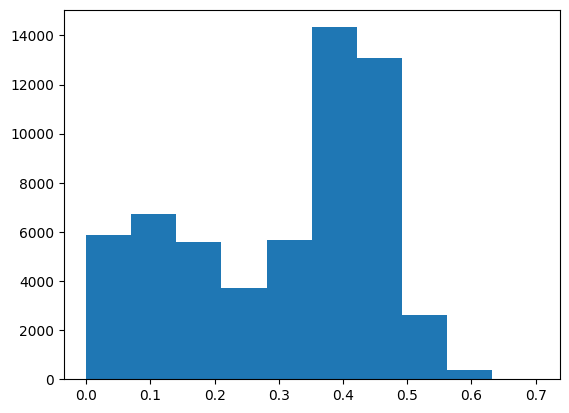

In [15]:
out = out = get_prob_M(4, ak.to_numpy(ak.flatten(eff_j)),ak.to_numpy(num_jets)) 
plt.hist(out);

## Now we need the conditional TRF prob

In [17]:
def get_conditiona_TRF(nA, nB, eff_j):
    '''
    nA = exact number of btagged jets
    given 
    nB = minimum number of btagged jets
    '''
    njets = ak.to_numpy(ak.num(eff_j, axis=1))
    effj = ak.to_numpy(ak.flatten(eff_j))
    P_B = np.ones(len(eff_j))
    for i in range(1, nB):  #from 0 to nB-1
        P_B -= get_prob_M(i, effj, njets) 
    # now the 0 tagged case

    P_B -= ak.to_numpy(ak.prod(1-eff_j, axis=1))
    
    P_A = get_prob_M(nA, effj, njets) 
    
    return P_A, P_B, P_A/P_B

In [18]:
get_conditiona_TRF(4, 2, eff_j)

(array([0.36604704, 0.09237936, 0.29623419, ..., 0.09435285, 0.43451779,
        0.48934083]),
 array([0.9698432 , 0.94608015, 0.99951174, ..., 0.94297512, 0.9881031 ,
        0.99640923]),
 array([0.37742909, 0.09764433, 0.2963789 , ..., 0.10005869, 0.43974945,
        0.49110427]))

In [19]:
%%timeit
get_conditiona_TRF(4, 2, eff_j)

6.13 s ± 24.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [20]:
P_A, P_B, P_AB = get_conditiona_TRF(4, 2, eff_j)

Text(0, 0.5, 'TRF P(4|2)')

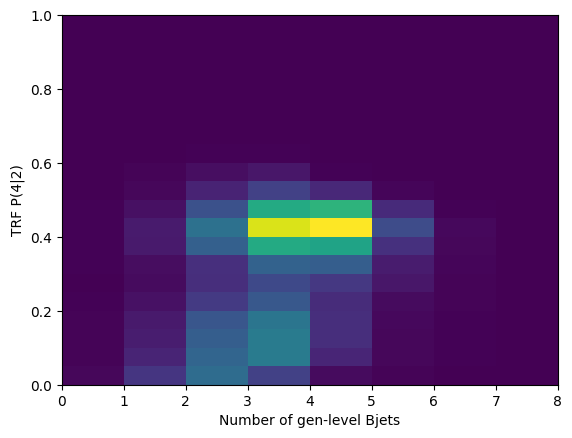

In [21]:
plt.hist2d(ak.to_numpy(nBjets), P_AB, 
          bins=(8, 20), range=((0.,8.),(0.,1.)));
plt.xlabel("Number of gen-level Bjets")
plt.ylabel("TRF P(4|2)")

Text(0, 0.5, 'TRF P(4|2)')

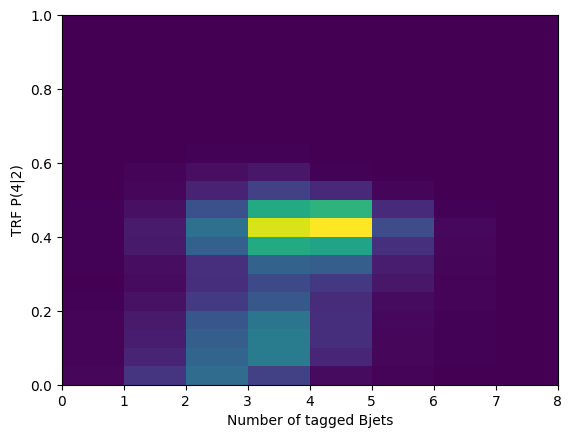

In [22]:
plt.hist2d(ak.to_numpy(nBjets), P_AB, 
          bins=(8, 20), range=((0.,8.),(0.,1.)));
plt.xlabel("Number of tagged Bjets")
plt.ylabel("TRF P(4|2)")

# Memory usage analysis

In [1]:
!pip install memory_profiler

In [ ]:
# Initial version
@numba.jit(nopython=True)
def get_prob_M(M, effs):
    '''Compute the probability of tagging M jets out of N total jets for each event.
    It takes as input the tagging efficiency for each jet in each event (awkward array)'''
    out = np.ones(len(effs))
    iev = 0
    
    for eff in effs:
        njets = len(eff)
        
        all_combinations_eff = 0.
        value = 1.
        for comb in combinations_numba(njets, M):
            # iterate on the combinations
            value = 1.
            for j, ef in zip(range(njets), eff):
                if j in comb:
                    value *= ef
                else:
                    value *= 1-ef
            #Sum the value for this combination to the total
            all_combinations_eff += value      
            
        out[iev] = all_combinations_eff
        iev+=1
    return out

In [13]:
%%memit
for i in range(20000):
    for comb in combinations_numba(25, 4):
        pass

peak memory: 343.06 MiB, increment: 0.00 MiB


In [9]:
%%file test_memory_trf.py

from numba import njit
import numpy as np

#Pure numba combinations implementation
#taken from https://stackoverflow.com/questions/61262188/numba-safe-version-of-itertools-combinations
@njit
def combinations_numba(n, r):
    pool = list(range(n))
    indices = list(range(r))
    empty = not(n and (0 < r <= n))

    if not empty:
        result = [pool[i] for i in indices]
        yield result

    while not empty:
        i = r - 1
        while i >= 0 and indices[i] == i + n - r:
            i -= 1
        if i < 0:
            empty = True
        else:
            indices[i] += 1
            for j in range(i+1, r):
                indices[j] = indices[j-1] + 1

            result = [pool[i] for i in indices]
            yield result
            
def get_prob_M_nonumba(M, effs):
    '''Compute the probability of tagging M jets out of N total jets for each event.
    It takes as input the tagging efficiency for each jet in each event (awkward array)'''
    out = np.ones(len(effs))
    iev = 0
    
    for eff in effs:
        njets = len(eff)
        
        all_combinations_eff = 0.
        for comb in combinations_numba(njets, M):
            # iterate on the combinations
            value = 1.
            for j in range(njets):
                if j in comb:
                    value *= eff[j]
                else:
                    value *= 1-eff[j]
            #Sum the value for this combination to the total
            all_combinations_eff += value      
            
        out[iev] = all_combinations_eff
        iev+=1
    return out

Overwriting test_memory_trf.py


In [39]:
%%memit
get_prob_M_nonumba(4, eff_j[0:100])

peak memory: 350.68 MiB, increment: 0.00 MiB


In [44]:
%%memit
get_prob_M(4, eff_j[0:50000])

peak memory: 5954.65 MiB, increment: 3094.68 MiB


In [10]:
from test_memory_trf import get_prob_M_nonumba
%mprun -f get_prob_M_nonumba get_prob_M_nonumba(4, eff_j[0:1000])

Filename: /work/dvalsecc/ttHbb/PocketCoffea/notebooks/test_memory_trf.py

Line #    Mem usage    Increment  Occurrences   Line Contents
    31    338.6 MiB    338.6 MiB           1   def get_prob_M_nonumba(M, effs):
    32                                             '''Compute the probability of tagging M jets out of N total jets for each event.
    33                                             It takes as input the tagging efficiency for each jet in each event (awkward array)'''
    34    338.6 MiB      0.0 MiB           1       out = np.ones(len(effs))
    35    338.6 MiB      0.0 MiB           1       iev = 0
    36                                             
    37    343.6 MiB      0.0 MiB        1001       for eff in effs:
    38    343.6 MiB      0.0 MiB        1000           njets = len(eff)
    39                                                 
    40    343.6 MiB      0.0 MiB        1000           all_combinations_eff = 0.
    41    343.6 MiB      4.8 MiB      365886      

In [11]:
%%memit 
get_prob_M_nonumba(4, eff_j[0:1000])

peak memory: 343.66 MiB, increment: 0.00 MiB


In [12]:
%%memit 
get_prob_M(4, eff_j[0:1000])

peak memory: 371.20 MiB, increment: 31.97 MiB


In [13]:
%%memit 
get_prob_M(4, eff_j[0:10000])

peak memory: 1002.29 MiB, increment: 631.02 MiB


In [14]:
%%memit 
get_prob_M(4, eff_j[0:20000])

peak memory: 2268.62 MiB, increment: 1266.24 MiB


In [26]:
eff_j.layout

<ListOffsetArray64>
    <offsets><Index64 i="[0 9 17 26 35 43 53 63 71 78 ... 592153 592164 592173 592181 592188 592198 592205 592215 592229 592243]" offset="0" length="57989" at="0x555f6f975020"/></offsets>
    <content><NumpyArray format="d" shape="592243" data="0.179724 0.776866 0.012372 0.759253 0.759253 ... 0.0338389 1 0.0429102 0.0432896 0.0429102" at="0x555f73b25610"/></content>
</ListOffsetArray64>

#### Trying to avoid awkward arrays

In [10]:
@numba.jit(nopython=True)
def get_prob_M_offset(M, effs, njets):
    '''Compute the probability of tagging M jets out of N total jets for each event.
    It takes as input the tagging efficiency for each jet in each event (awkward array)'''
    out = np.ones(len(njets))
    offset = 0
    for iev in range(len(njets)):
        njets_this_ev = njets[iev]

        all_combinations_eff = 0.
        value = 1.
        for comb in combinations_numba(njets_this_ev, M):
            # iterate on the combinations
            value = 1.
            for j in range(njets_this_ev):
                if j in comb:
                    value *= eff[offset + j]
                else:
                    value *= 1-eff[offset + j]
            #Sum the value for this combination to the total
            all_combinations_eff += value      
            
        offset += njets_this_ev
        out[iev] = all_combinations_eff
        iev+=1
    return out

In [39]:
%%memit
get_prob_M_offset(4, ak.to_numpy(ak.flatten(eff_j)), ak.to_numpy(num_jets))

peak memory: 16095.53 MiB, increment: 3587.84 MiB


In [45]:
%%memit
out2= get_prob_M(4, eff_j)

peak memory: 26860.62 MiB, increment: 3588.48 MiB


#### Just looping

In [37]:
@numba.jit(nopython=True)
def test_only_loop(M, effs, njets):
    '''Compute the probability of tagging M jets out of N total jets for each event.
    It takes as input the tagging efficiency for each jet in each event (awkward array)'''
    out = np.ones(len(njets))
    offset = 0
    for iev in range(len(njets)):
        njets_this_ev = njets[iev]
        value = 1.
        for comb in combinations_numba(njets_this_ev, M):
            value+=1    
    return out

@numba.jit(nopython=True)
def test_only_loop_nogenerator(M, effs, njets):
    '''Compute the probability of tagging M jets out of N total jets for each event.
    It takes as input the tagging efficiency for each jet in each event (awkward array)'''
    out = np.ones(len(njets))
    offset = 0
    for iev in range(len(njets)):
        njets_this_ev = njets[iev]
        value = 1.
        for comb in combinations_numba_nogenerator(njets_this_ev, M):
            value+=1    
    return out

In [22]:
test_only_loop(4, ak.to_numpy(ak.flatten(eff_j)), ak.to_numpy(num_jets))

array([1., 1., 1., ..., 1., 1., 1.])

In [23]:
%%memit
test_only_loop(4, ak.to_numpy(ak.flatten(eff_j)), ak.to_numpy(num_jets))

peak memory: 14661.02 MiB, increment: 3588.14 MiB


In [38]:
test_only_loop_nogenerator(4, ak.to_numpy(ak.flatten(eff_j)), ak.to_numpy(num_jets))

array([1., 1., 1., ..., 1., 1., 1.])

In [39]:
%%memit
test_only_loop_nogenerator(4, ak.to_numpy(ak.flatten(eff_j)), ak.to_numpy(num_jets))

peak memory: 14669.00 MiB, increment: 0.07 MiB


**The issue was in the numba generator!!** Materializing the list of combinations and looping over it does not leak memory!

#### Final function compations

offset vs awkward arrays for the jets efficiencies

In the *offset* version, the jets efficiencies are flattened and a numpy array is passed to the function instead of an awkward array. 
This saves some time

In [40]:
@numba.jit(nopython=True)
def get_prob_M_offset_nogenerator(M, effs, njets):
    '''Compute the probability of tagging M jets out of N total jets for each event.
    It takes as input the tagging efficiency for each jet in each event (awkward array)'''
    out = np.ones(len(njets))
    offset = 0
    for iev in range(len(njets)):
        njets_this_ev = njets[iev]

        all_combinations_eff = 0.
        value = 1.
        for comb in combinations_numba_nogenerator(njets_this_ev, M):
            # iterate on the combinations
            value = 1.
            for j in range(njets_this_ev):
                if j in comb:
                    value *= eff[offset + j]
                else:
                    value *= 1-eff[offset + j]
            #Sum the value for this combination to the total
            all_combinations_eff += value      
            
        offset += njets_this_ev
        out[iev] = all_combinations_eff
        iev+=1
    return out

In [43]:
get_prob_M_offset_nogenerator(4, ak.to_numpy(ak.flatten(eff_j)), ak.to_numpy(num_jets))

array([0.36604704, 0.09237936, 0.29623419, ..., 0.09435285, 0.43451779,
       0.48934083])

In [44]:
%%memit
get_prob_M_offset_nogenerator(4, ak.to_numpy(ak.flatten(eff_j)), ak.to_numpy(num_jets))

peak memory: 21847.66 MiB, increment: 0.11 MiB


##### Keeping the awkward array

In [45]:
@numba.jit(nopython=True)
def get_prob_M_nogenerator(M, effs):
    '''Compute the probability of tagging M jets out of N total jets for each event.
    It takes as input the tagging efficiency for each jet in each event (awkward array)'''
    out = np.ones(len(effs))
    iev = 0
    
    for eff in effs:
        njets = len(eff)
        
        all_combinations_eff = 0.
        value = 1.
        for comb in combinations_numba_nogenerator(njets, M):
            # iterate on the combinations
            value = 1.
            for j, ef in zip(range(njets), eff):
                if j in comb:
                    value *= ef
                else:
                    value *= 1-ef
            #Sum the value for this combination to the total
            all_combinations_eff += value      
            
        out[iev] = all_combinations_eff
        iev+=1
    return out

In [47]:
get_prob_M_nogenerator(4, eff_j)

array([0.36604704, 0.09237936, 0.29623419, ..., 0.09435285, 0.43451779,
       0.48934083])

In [48]:
%%memit
get_prob_M_nogenerator(4, eff_j)

peak memory: 21848.73 MiB, increment: 0.00 MiB


In [56]:
%%timeit -r 20
get_prob_M_nogenerator(4, eff_j[:10000])

1.13 s ± 10.7 ms per loop (mean ± std. dev. of 20 runs, 1 loop each)


In [57]:
%%timeit -r 20
get_prob_M_offset_nogenerator(4, ak.to_numpy(ak.flatten(eff_j[:10000])), ak.to_numpy(num_jets[:10000]))

1.1 s ± 9.43 ms per loop (mean ± std. dev. of 20 runs, 1 loop each)


The offset version is slightly better